In [1]:
from scipy.io import loadmat
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

## a. 
Implement the low-rank approximation (with r= 5) and perform EM algorithm. Use the similar initialization method as the last question. Plot the log-likelihood function versus the number of iterations to show your algorithm is converging.

In [2]:
images = loadmat('data/data.mat')['data']
labels = loadmat('data/label.mat')['trueLabel']

K = 2  # number of clusters
d = 5  # reduced dimension
seed = 3836
np.random.seed(seed)
images = images.T
m, n = images.shape
cimages = images - np.mean(images, axis=0)

In [3]:
def lowrank_mvn_pdf(X, mu, s, r=5):
    evals, evecs = np.linalg.eig(s)
    evecs = evecs[:,np.argsort(-evals)][:,:r]
    evals = evals[np.argsort(-evals)][:r]
    X = X.dot(evecs)
    mu = mu.dot(evecs)
    prob = 1/np.sqrt(np.prod(evals)) * np.exp(-1/2 * np.sum((X-mu)**2 / evals, axis=1))
    prob = prob.real
    return prob

In [4]:
def gen_random_input(clus, dim):
    pi = np.random.rand(clus)
    pi = pi/np.sum(pi)
    mu = np.random.rand(clus,dim)
    sigma = []
    for ii in range(clus):
        # to ensure the covariance psd
        # np.random.seed(seed)
        dummy = np.random.randn(dim, dim)
        sigma.append(dummy@dummy.T)
    sigma = np.array(sigma) + np.eye(dim)
    return pi, mu, sigma

In [5]:
pi, mu, sigma = gen_random_input(K, n)
mu_old = mu.copy()
tau = np.full((m, K), fill_value=0.)

In [6]:
maxIter= 200
tol = 1e-4

ll = []
for ii in range(maxIter):

    # E-step    
    for kk in range(K):
        tau[:, kk] = pi[kk] * lowrank_mvn_pdf(cimages, mu[kk], sigma[kk], r=5)
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m,1)    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
    ll.append(np.sum(np.log(sum_tau))) 
    
    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = cimages.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        
        # update cov matrix
        dummy = cimages - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
        
    # print('-----iteration---',ii)    
    if np.linalg.norm(mu-mu_old) < tol:
        # print('training coverged')
        break
    mu_old = mu.copy()
    if ii==maxIter-1:
        # print('max iteration reached')
        break

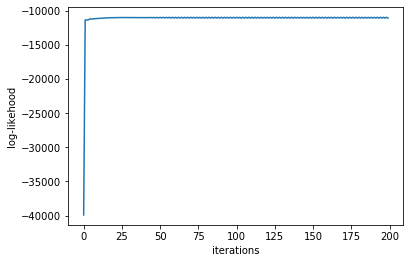

In [7]:
plt.plot(ll)
plt.xlabel('iterations')
plt.ylabel('log-likehood')
plt.savefig('data/HW3_Q3a_r5.png')

## b.
Use  the τik to  infer  the  labels  of  the  images,  and  compare  with  the  truelabels.  Report the misclassification rate for digits “2” and “6” respectively.  Comparewith GMM using PCA that you have implemented in Question 2.  Which one achieves better performance?

In [12]:
def ifelse(cond, a, b):
    if cond:
        return a
    else:
        return b

predictions = np.array([ifelse(t[0] >= t[1], 0, 1) for t in tau])
actuals = [ifelse(a==2, 0, 1) for a in labels.flatten().tolist()]
diffs = np.abs(np.array(predictions) - np.array(actuals))
misclassify = np.sum(diffs)/diffs.shape[0]
idx2 = np.where(labels == 2)[1]
idx6 = np.where(labels == 6)[1]
miss2 = sum(predictions[idx2])/predictions[idx2].shape[0]
miss6 = 1 - sum(predictions[idx6])/predictions[idx6].shape[0]
print(f"total misclassification rate: {misclassify}")
print(f"2 misclassification rate: {miss2}")
print(f"6 misclassification rate: {miss6}")

total misclassification rate: 0.04472361809045226
2 misclassification rate: 0.044573643410852716
6 misclassification rate: 0.044885177453027114
